#    Hyperparameter Tuning for Intent Classification using LSTM with Attention Mechanism
This notebook is 2nd part of the Ultimate AI Challenge. In the previous notebook, we trained a LSTM Model with Attention Mechanism for Intent Classification on the ATIS dataset. In this notebook, we perform a hyper parameter optimization to learn the best parameters for the model and also log our experiments using an ML server, e.g. MLFlow. Propreitart clouds already use experiment logging, model registry and deployment services, e.g. Vertex AI in GCP, Azure ML and Amazon Sagemaker. I have worked in Vertex AI and Azure ML. MLflow + Optuna is a good open source and scalable alternative to them. We use Optuna for hyperparameter tuning and MLflow for experiment tracking and model registry. Model Serving is done through pytorch save and load methods. To avoid pickling and version issues, we can also use model state dictionaries. The notebook is divided into the following sections:
1. Data Preparation
2. Hyperparameter Tuning
3. Model Training and Evaluation
4. Visualize the results
5. Model Export, Registry, Model Loading and Inference

Let's start

In [1]:
import sys
from sklearn.model_selection import KFold
import torch.nn as nn
from machine_learning.IntentClassifierLSTMWithAttention import IntentClassifierLSTMWithAttention
from machine_learning.IntentTokenizer import IntentTokenizer
import torch.optim as optim
import pandas as pd
import torch
from torch.utils.data import DataLoader
from machine_learning.model_utils import train, evaluate, predict, get_or_create_experiment
import optuna
import logging
import mlflow
from optuna.visualization import plot_optimization_history
import matplotlib.pyplot as plt



device=torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [10]:
import warnings
warnings.filterwarnings("ignore")

## Data Preparation
Steps:
1. Load the data
2. Tokenize the data
3. Create a PyTorch Dataset
4. Create a PyTorch DataLoader

In [2]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

train_df = pd.read_csv('data/atis/train.tsv', sep='\t', header=None, names=["text", "label"])
test_df = pd.read_csv('data/atis/test.tsv', sep='\t', header=None, names=["text", "label"])
tokenizer = IntentTokenizer(train_df)

# define constants and hyperparameters
vocab_size=tokenizer.max_vocab_size+1
output_dim=len(tokenizer.le.classes_)
batch_size = 32
num_epochs = 5

train_data = tokenizer.process_data(train_df, device=device)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
print("Number of training samples:", train_data.tensors[0].size())
print("Number of training batches:", len(train_loader))

test_data = tokenizer.process_data(test_df, device=device)
print("Number of test samples:", test_data.tensors[0].size())
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
print("Number of test batches:", len(test_loader))

inside IntentTokenizer
Vocabulary Size: 890
Encoding labels for the first time and adding unknown class.
Label Encoding: {'abbreviation': 0, 'aircraft': 1, 'aircraft+flight+flight_no': 2, 'airfare': 3, 'airfare+flight_time': 4, 'airline': 5, 'airline+flight_no': 6, 'airport': 7, 'capacity': 8, 'cheapest': 9, 'city': 10, 'distance': 11, 'flight': 12, 'flight+airfare': 13, 'flight_no': 14, 'flight_time': 15, 'ground_fare': 16, 'ground_service': 17, 'ground_service+ground_fare': 18, 'meal': 19, 'quantity': 20, 'restriction': 21, '<unknown>': 22}
Number of training samples: torch.Size([4634, 46])
Number of training batches: 145
Number of test samples: torch.Size([850, 30])
Number of test batches: 27


## Hyperparameter Tuning
The Model that we are using for the hyperparameter tuning is the IntentClassifierLSTMWithAttention. The hyperparameters that we are tuning are:
1. Learning rate : 1e-3 to 1e-1
2. Hidden dimension : 32, 64, 128, 256
3. Embedding dimension : 64, 128, 256, 512
4. Dropout rate : 0.1 to 0.5
5. Weight decay : 1e-6 to 1e-3

The objective function is the average validation accuracy over 5 folds. The best model is the one with the highest average validation accuracy. Note our test data is completely hidden to the accuracy optimizer of optuna. We can choose any metric to optimize, for example minimization of loss, etc..

In [61]:
def log_hyperparameters(trial):
    # Log hyperparameters
    
    mlflow.log_param("lr", trial.params["lr"])
    mlflow.log_param("hidden_dim", trial.params["hidden_dim"])
    mlflow.log_param("embedding_dim", trial.params["embedding_dim"])
    mlflow.log_param("dropout_rate", trial.params["dropout_rate"])
    mlflow.log_param("weight_decay", trial.params["weight_decay"])
    print(f'lr: {trial.params["lr"]}, hidden_dim: {trial.params["hidden_dim"]}, embedding_dim: {trial.params["embedding_dim"]}, dropout_rate: {trial.params["dropout_rate"]}, weight_decay: {trial.params["weight_decay"]}')

    return

def log_metrics(trial, accuracy):
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    return
def objective(trial):
    with mlflow.start_run():
        # Suggest hyperparameters
        lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 256])
        embedding_dim = trial.suggest_categorical("embedding_dim", [64, 128, 256])
        dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
        weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
        criterion = nn.CrossEntropyLoss()
        log_hyperparameters(trial)
        # Model, loss, and optimizer
        # model = IntentClassifierLSTM(cfg.vocab_size, embedding_dim, hidden_dim, cfg.output_dim,dropout_rate).to(device)
        model = IntentClassifierLSTMWithAttention(vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        fold_val_acc = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
            # Prepare fold data
            train_data_subset = tokenizer.process_data(train_df.loc[train_idx,:], device=device)
            val_data_subset = tokenizer.process_data(train_df.loc[val_idx,:], device=device)
            train_subset_loader = DataLoader(train_data_subset, batch_size=batch_size, shuffle=True)
            val_subset_loader = DataLoader(val_data_subset, batch_size=batch_size, shuffle=False)
            fold_loss = train(model, optimizer, criterion, train_subset_loader, num_epochs)
            val_accuracy = evaluate(model,  criterion, val_subset_loader, data_type="Validation")
            print(f'Fold: {fold + 1}, Training Loss: {fold_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            fold_val_acc.append(val_accuracy)
        average_val_acc = sum(fold_val_acc) / len(fold_val_acc)
        print(f'Average validation accuracy: {average_val_acc:.4f}')
        log_metrics(trial, average_val_acc)
    return average_val_acc

## Optuna Study for Hyperparameter Optimization
Create an experiment in MLflow and run the hyperparameter tuning experiment. The best model is the one with the highest average validation accuracy. You can install the mlflow and optuna using pip install. To start mlflow server, I used the following command
`mlflow server --backend-store-uri=sqlite:///mlrunsdb15.db --default-artifact-root=file:mlruns --host 127.0.0.1 --port 1234`
Once started, it creates mlruns directory in project root and also a db in the root to log the progress, store models and experiments. In practise, it is installed on a server, and http requests are sent to the server. Anyhow pay close attention to the  Here we keep it simple. Optuna also creates a db to store it's studies. Here we choose 20 tries. For 5 folds cross validation, and 5 epochs each, the study takes less than an hour my M1 machine. Optuna uses Bayesian Parameter Optimization.

In [ ]:
mlflow.set_tracking_uri('http://127.0.0.1:1234')
study_name = "IntentClassifierLSTMWithAttention_small"
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,load_if_exists=True,direction="maximize")
study.optimize(objective, n_trials=20)
best_trial = study.best_trial

lr: 0.0029129252046828265, hidden_dim: 32, embedding_dim: 64, dropout_rate: 0.3621992380721305, weight_decay: 0.00013176550053080663
Epoch [1/5], Loss: 1.6434, Accuracy: 0.6577
Epoch [2/5], Loss: 0.5652, Accuracy: 0.8740
Epoch [3/5], Loss: 0.3716, Accuracy: 0.9088
Epoch [4/5], Loss: 0.2770, Accuracy: 0.9288
Epoch [5/5], Loss: 0.2278, Accuracy: 0.9428
Validation Loss: 0.1439
Validation Accuracy: 0.9601
Fold: 1, Training Loss: 0.2278, Validation Accuracy: 0.9601
Epoch [1/5], Loss: 0.1955, Accuracy: 0.9482
Epoch [2/5], Loss: 0.1380, Accuracy: 0.9628
Epoch [3/5], Loss: 0.1157, Accuracy: 0.9722
Epoch [4/5], Loss: 0.1016, Accuracy: 0.9714
Epoch [5/5], Loss: 0.0911, Accuracy: 0.9776
Validation Loss: 0.1126
Validation Accuracy: 0.9763
Fold: 2, Training Loss: 0.0911, Validation Accuracy: 0.9763
Epoch [1/5], Loss: 0.1024, Accuracy: 0.9728
Epoch [2/5], Loss: 0.0865, Accuracy: 0.9768
Epoch [3/5], Loss: 0.0652, Accuracy: 0.9819
Epoch [4/5], Loss: 0.0525, Accuracy: 0.9860
Epoch [5/5], Loss: 0.0496, 

## Best Model Training and Evaluation
Once we find the best set of hyper parameters, you can open mlflow on tracking uri, e.g. in my case , I set http://127.0.0.1:1234. Also if you install optuna-dashboard, you can see very nice visualizations and get very detailed insights on hyperparameter space, their importance, and why some combinations work more than others. I invite to try it. Tune the best model with a larger number of epochs and evaluate it on the test set. You can reload an optuna study from its' db later to get the best parameters and train a model.

In [27]:
warnings.filterwarnings("ignore", category=FutureWarning, module="mlflow.*")
import exceptions

ModuleNotFoundError: No module named 'exceptions'

In [ ]:
# Reload Optuna Study to get the best parameters
experiment_id=get_or_create_experiment('Best E-LSTMWithAttention')
study_name = "IntentClassifierLSTMWithAttention_small"
storage_name = "sqlite:///{}.db".format(study_name)
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(study_name=study_name, storage=storage_name,load_if_exists=True,direction="maximize")
best_trial = study.best_trial

# Train the model using best parameters
model = IntentClassifierLSTMWithAttention(
    vocab_size,
    best_trial.params['embedding_dim'],
    best_trial.params['hidden_dim'],
    output_dim,
    best_trial.params['dropout_rate']
).to(device)

optimizer = optim.Adam(model.parameters(), lr=best_trial.params['lr'],
                       weight_decay=best_trial.params['weight_decay'])
train_loss = train(model, optimizer, nn.CrossEntropyLoss(), train_loader, 20)
test_accuracy = evaluate(model, nn.CrossEntropyLoss(), test_loader, data_type="Test")
print(f'Test Accuracy: {test_accuracy:.4f}')

## Visualize the results
Optuna provides a number of visualizations to analyze the results of the hyperparameter tuning experiment. We can use these visualizations to analyze the results of the hyperparameter tuning experiment.

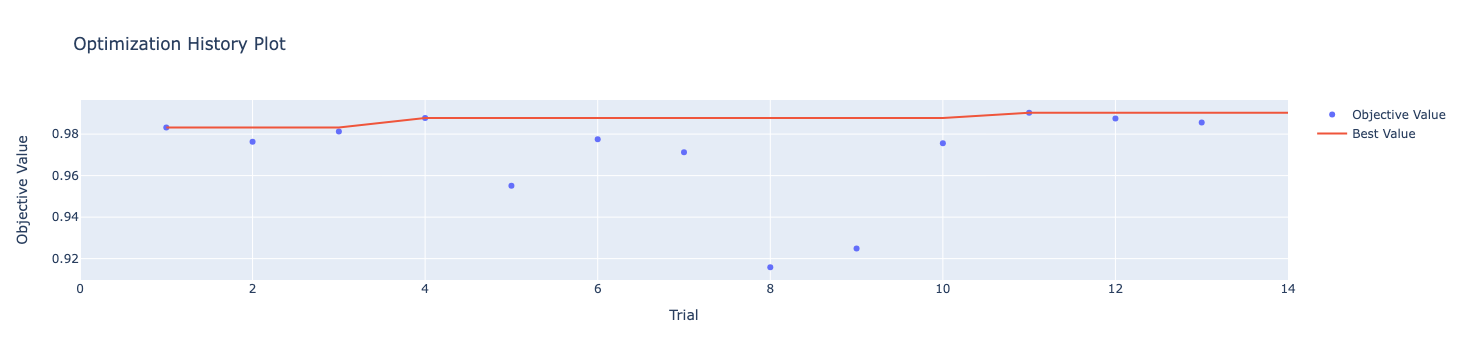

In [23]:
# Visualize the optimization history
# Generate the Optuna plot
fig = optuna.visualization.plot_optimization_history(study)
fig
#for way nicer plotly figures, use 
#fig = optuna.visualization.plot_optimization_history(study)
#fig.save_html("plot_optimization_history.html")

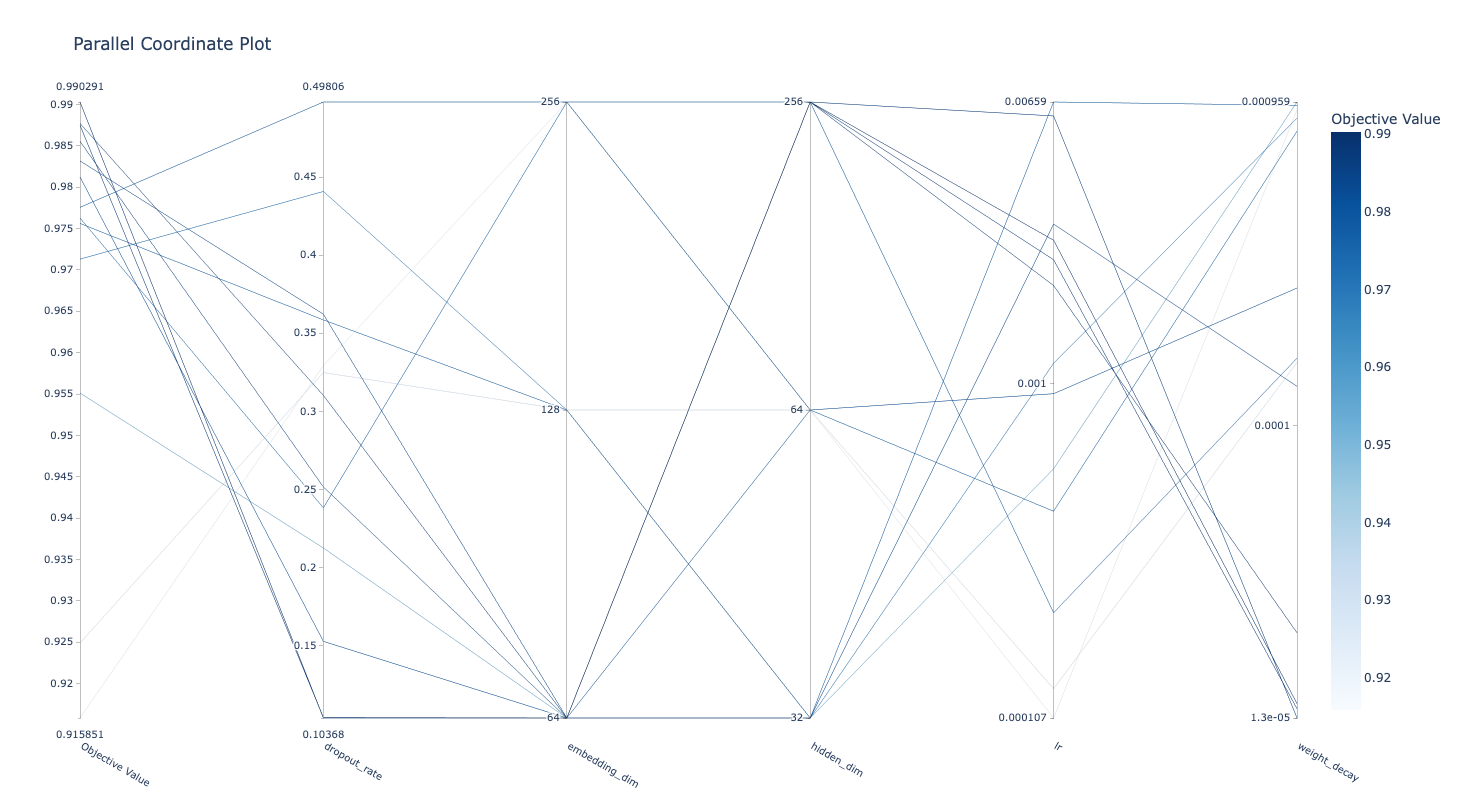

In [30]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(
    width=1600,   # Width of the figure in pixels
    height=800   # Height of the figure in pixels
)
fig

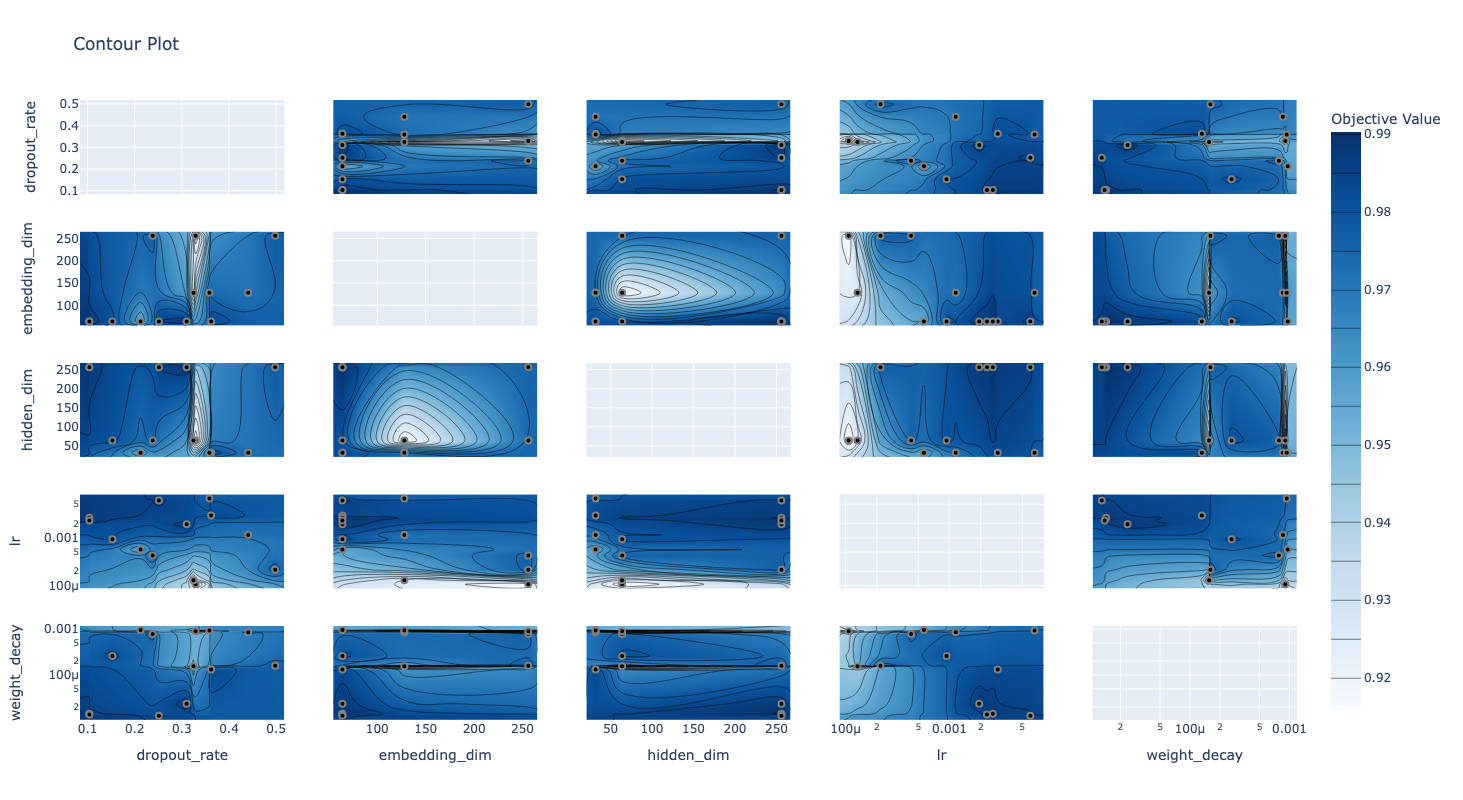

In [29]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(
    width=1600,   # Width of the figure in pixels
    height=800   # Height of the figure in pixels
)
fig

## Save the model and check model Serving

In [ ]:
model_name = "best_ICELSTMAmodel"
torch.save(model, f"models/{model_name}.pth")
tokenizer.save_state(f"models/{model_name}_tokenizer.pickle", f"models/{model_name}_le.pickle")

In [ ]:
# Load the trained model and tokenizer from saved files
model_serve = torch.load(f"models/{model_name}.pth").to(device)
tokenizer = IntentTokenizer.load_state(IntentTokenizer,f"models/{model_name}_tokenizer.pickle", f"models/{model_name}_le.pickle")
max_query_length = 50
query_text = "what airlines off from love field between 6 and 10 am on june sixth"
query = pd.DataFrame({"text": [query_text]})
prediction = predict(model_serve, query,tokenizer,device)
print(f"Predicted label: {prediction}")